# 03. Class Imbalance Analysis and Solutions

## Objective
Analyze class imbalance issues, especially for the "Improving" class, and implement solutions to improve model performance on minority classes.

## Key Questions
1. What is the class distribution?
2. How does class imbalance affect model performance?
3. What techniques can improve performance on minority classes?
4. Which approach works best for this problem?


In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, roc_auc_score
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from imblearn.over_sampling import SMOTE, ADASYN, RandomOverSampler
from imblearn.under_sampling import RandomUnderSampler
from imblearn.combine import SMOTETomek
from imblearn.pipeline import Pipeline as ImbPipeline
import warnings
warnings.filterwarnings('ignore')

sns.set(style="whitegrid")
plt.rcParams['figure.figsize'] = (12, 6)

print("✅ Libraries imported")


✅ Libraries imported


## 1. Load Data and Analyze Class Distribution


CLASS DISTRIBUTION ANALYSIS

Training Set:
  Declining:  3775 (39.15%)
  Stable:  4555 (47.24%)
  Improving:  1313 (13.62%)

Test Set:
  Declining:   944 (39.15%)
  Stable:  1139 (47.24%)
  Improving:   328 (13.60%)

Imbalance Ratio: 3.47:1
(Most common class is 3.5x larger than least common)


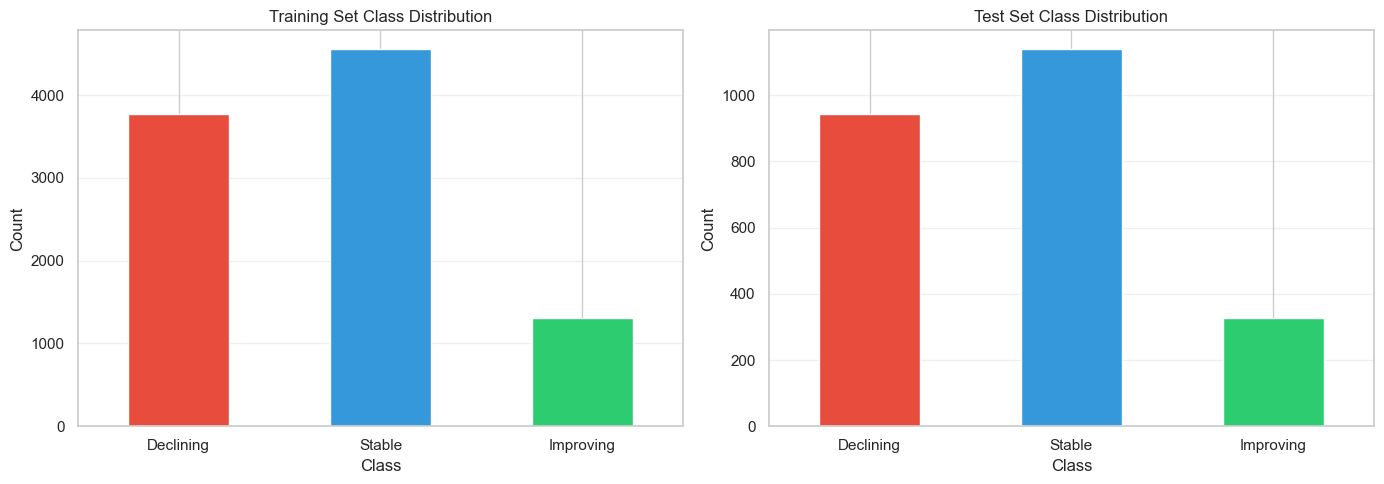


📊 Chart saved as 'class_distribution.png'


In [2]:
# Load data
df = pd.read_csv('../today/trajectory_ml_ready_advanced.csv')

# Prepare features and target
drop_cols = ['UNITID', 'Institution_Name', 'Year', 'Target_Trajectory', 'Target_Label', 'State']
X = df.drop(columns=drop_cols)
y = df['Target_Label'].astype(int)

# One-hot encode Division
X = pd.get_dummies(X, columns=['Division'], drop_first=True)

# Split data
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, stratify=y, random_state=42
)

# Analyze class distribution
print("=" * 60)
print("CLASS DISTRIBUTION ANALYSIS")
print("=" * 60)

class_names = {0: 'Declining', 1: 'Stable', 2: 'Improving'}

print("\nTraining Set:")
train_dist = y_train.value_counts().sort_index()
for label, count in train_dist.items():
    pct = count / len(y_train) * 100
    print(f"  {class_names[label]}: {count:5d} ({pct:5.2f}%)")

print("\nTest Set:")
test_dist = y_test.value_counts().sort_index()
for label, count in test_dist.items():
    pct = count / len(y_test) * 100
    print(f"  {class_names[label]}: {count:5d} ({pct:5.2f}%)")

# Calculate imbalance ratio
max_class_count = train_dist.max()
min_class_count = train_dist.min()
imbalance_ratio = max_class_count / min_class_count

print(f"\nImbalance Ratio: {imbalance_ratio:.2f}:1")
print(f"(Most common class is {imbalance_ratio:.1f}x larger than least common)")

# Visualize
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Training set
train_dist.plot(kind='bar', ax=axes[0], color=['#e74c3c', '#3498db', '#2ecc71'])
axes[0].set_title('Training Set Class Distribution')
axes[0].set_xlabel('Class')
axes[0].set_ylabel('Count')
axes[0].set_xticklabels([class_names[i] for i in train_dist.index], rotation=0)
axes[0].grid(axis='y', alpha=0.3)

# Test set
test_dist.plot(kind='bar', ax=axes[1], color=['#e74c3c', '#3498db', '#2ecc71'])
axes[1].set_title('Test Set Class Distribution')
axes[1].set_xlabel('Class')
axes[1].set_ylabel('Count')
axes[1].set_xticklabels([class_names[i] for i in test_dist.index], rotation=0)
axes[1].grid(axis='y', alpha=0.3)

plt.tight_layout()
plt.savefig('class_distribution.png', dpi=150, bbox_inches='tight')
plt.show()

print("\n📊 Chart saved as 'class_distribution.png'")


## 2. Baseline Model Performance (Without Balancing)


BASELINE MODEL (No Balancing)
Accuracy: 0.5682
ROC-AUC: 0.7078

Per-Class Performance:
              precision    recall  f1-score   support

   Declining       0.53      0.47      0.50       944
      Stable       0.59      0.80      0.68      1139
   Improving       0.38      0.04      0.07       328

    accuracy                           0.57      2411
   macro avg       0.50      0.44      0.42      2411
weighted avg       0.54      0.57      0.53      2411



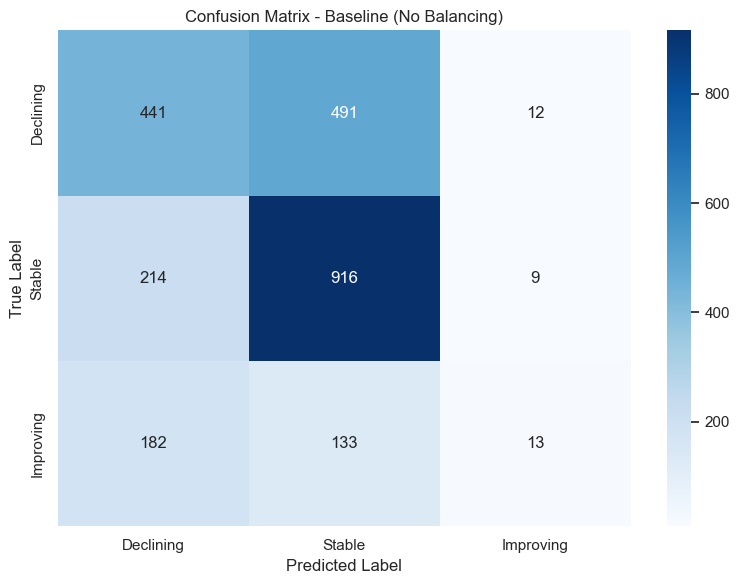

In [3]:
# Train XGBoost without any balancing
xgb_baseline = XGBClassifier(
    n_estimators=100,
    max_depth=3,
    learning_rate=0.1,
    random_state=42,
    eval_metric='mlogloss'
)

xgb_baseline.fit(X_train, y_train)
y_pred_baseline = xgb_baseline.predict(X_test)
y_prob_baseline = xgb_baseline.predict_proba(X_test)

print("=" * 60)
print("BASELINE MODEL (No Balancing)")
print("=" * 60)
print(f"Accuracy: {accuracy_score(y_test, y_pred_baseline):.4f}")
print(f"ROC-AUC: {roc_auc_score(y_test, y_prob_baseline, multi_class='ovr'):.4f}")

print("\nPer-Class Performance:")
print(classification_report(y_test, y_pred_baseline, 
                          target_names=['Declining', 'Stable', 'Improving']))

# Confusion matrix
cm_baseline = confusion_matrix(y_test, y_pred_baseline)
plt.figure(figsize=(8, 6))
sns.heatmap(cm_baseline, annot=True, fmt='d', cmap='Blues',
            xticklabels=['Declining', 'Stable', 'Improving'],
            yticklabels=['Declining', 'Stable', 'Improving'])
plt.title('Confusion Matrix - Baseline (No Balancing)')
plt.ylabel('True Label')
plt.xlabel('Predicted Label')
plt.tight_layout()
plt.savefig('confusion_baseline.png', dpi=150, bbox_inches='tight')
plt.show()


## 3. Test Different Balancing Techniques


In [5]:
# Define balancing techniques to test
balancing_techniques = {
    'SMOTE': SMOTE(random_state=42),
    'ADASYN': ADASYN(random_state=42),
    'RandomOverSampler': RandomOverSampler(random_state=42),
    'SMOTETomek': SMOTETomek(random_state=42),
    'Class Weights (XGBoost)': None  # Will use scale_pos_weight parameter
}

results = []

for name, sampler in balancing_techniques.items():
    print(f"\n{'='*60}")
    print(f"Testing: {name}")
    print('='*60)
    
    try:
        if name == 'Class Weights (XGBoost)':
            # Use class weights instead of sampling
            from sklearn.utils.class_weight import compute_sample_weight
            sample_weights = compute_sample_weight('balanced', y_train)
            
            xgb_weighted = XGBClassifier(
                n_estimators=100,
                max_depth=3,
                learning_rate=0.1,
                random_state=42,
                eval_metric='mlogloss'
            )
            xgb_weighted.fit(X_train, y_train, sample_weight=sample_weights)
            y_pred = xgb_weighted.predict(X_test)
            y_prob = xgb_weighted.predict_proba(X_test)
        else:
            # Use sampling technique
            pipeline = ImbPipeline([
                ('sampler', sampler),
                ('classifier', XGBClassifier(
                    n_estimators=100,
                    max_depth=3,
                    learning_rate=0.1,
                    random_state=42,
                    eval_metric='mlogloss'
                ))
            ])
            pipeline.fit(X_train, y_train)
            y_pred = pipeline.predict(X_test)
            y_prob = pipeline.predict_proba(X_test)
        
        # Calculate metrics
        accuracy = accuracy_score(y_test, y_pred)
        roc_auc = roc_auc_score(y_test, y_prob, multi_class='ovr')
        
        # Per-class metrics
        report = classification_report(y_test, y_pred, 
                                     target_names=['Declining', 'Stable', 'Improving'],
                                     output_dict=True)
        
        results.append({
            'Technique': name,
            'Accuracy': accuracy,
            'ROC-AUC': roc_auc,
            'Declining_F1': report['Declining']['f1-score'],
            'Stable_F1': report['Stable']['f1-score'],
            'Improving_F1': report['Improving']['f1-score'],
            'Macro_F1': report['macro avg']['f1-score']
        })
        
        print(f"Accuracy: {accuracy:.4f}")
        print(f"ROC-AUC: {roc_auc:.4f}")
        print(f"Macro F1: {report['macro avg']['f1-score']:.4f}")
        print(f"Improving F1: {report['Improving']['f1-score']:.4f}")
    except ValueError as err:
        print(f"⚠️  Skipped {name} due to error: {err}")
        continue

# Create results dataframe
results_df = pd.DataFrame(results)
print("\n" + "="*60)
print("COMPARISON OF BALANCING TECHNIQUES")
print("="*60)
print(results_df.to_string(index=False))


Testing: SMOTE
Accuracy: 0.5081
ROC-AUC: 0.6940
Macro F1: 0.4575
Improving F1: 0.3707

Testing: ADASYN
⚠️  Skipped ADASYN due to error: No samples will be generated with the provided ratio settings.

Testing: RandomOverSampler
Accuracy: 0.5081
ROC-AUC: 0.6940
Macro F1: 0.4575
Improving F1: 0.3707

Testing: ADASYN
⚠️  Skipped ADASYN due to error: No samples will be generated with the provided ratio settings.

Testing: RandomOverSampler
Accuracy: 0.5031
ROC-AUC: 0.6940
Macro F1: 0.4509
Improving F1: 0.3727

Testing: SMOTETomek
Accuracy: 0.5031
ROC-AUC: 0.6940
Macro F1: 0.4509
Improving F1: 0.3727

Testing: SMOTETomek
Accuracy: 0.5002
ROC-AUC: 0.6973
Macro F1: 0.4482
Improving F1: 0.3717

Testing: Class Weights (XGBoost)
Accuracy: 0.5002
ROC-AUC: 0.6973
Macro F1: 0.4482
Improving F1: 0.3717

Testing: Class Weights (XGBoost)
Accuracy: 0.4994
ROC-AUC: 0.6960
Macro F1: 0.4459
Improving F1: 0.3715

COMPARISON OF BALANCING TECHNIQUES
              Technique  Accuracy  ROC-AUC  Declining_F1  S

## 4. Visualize Results


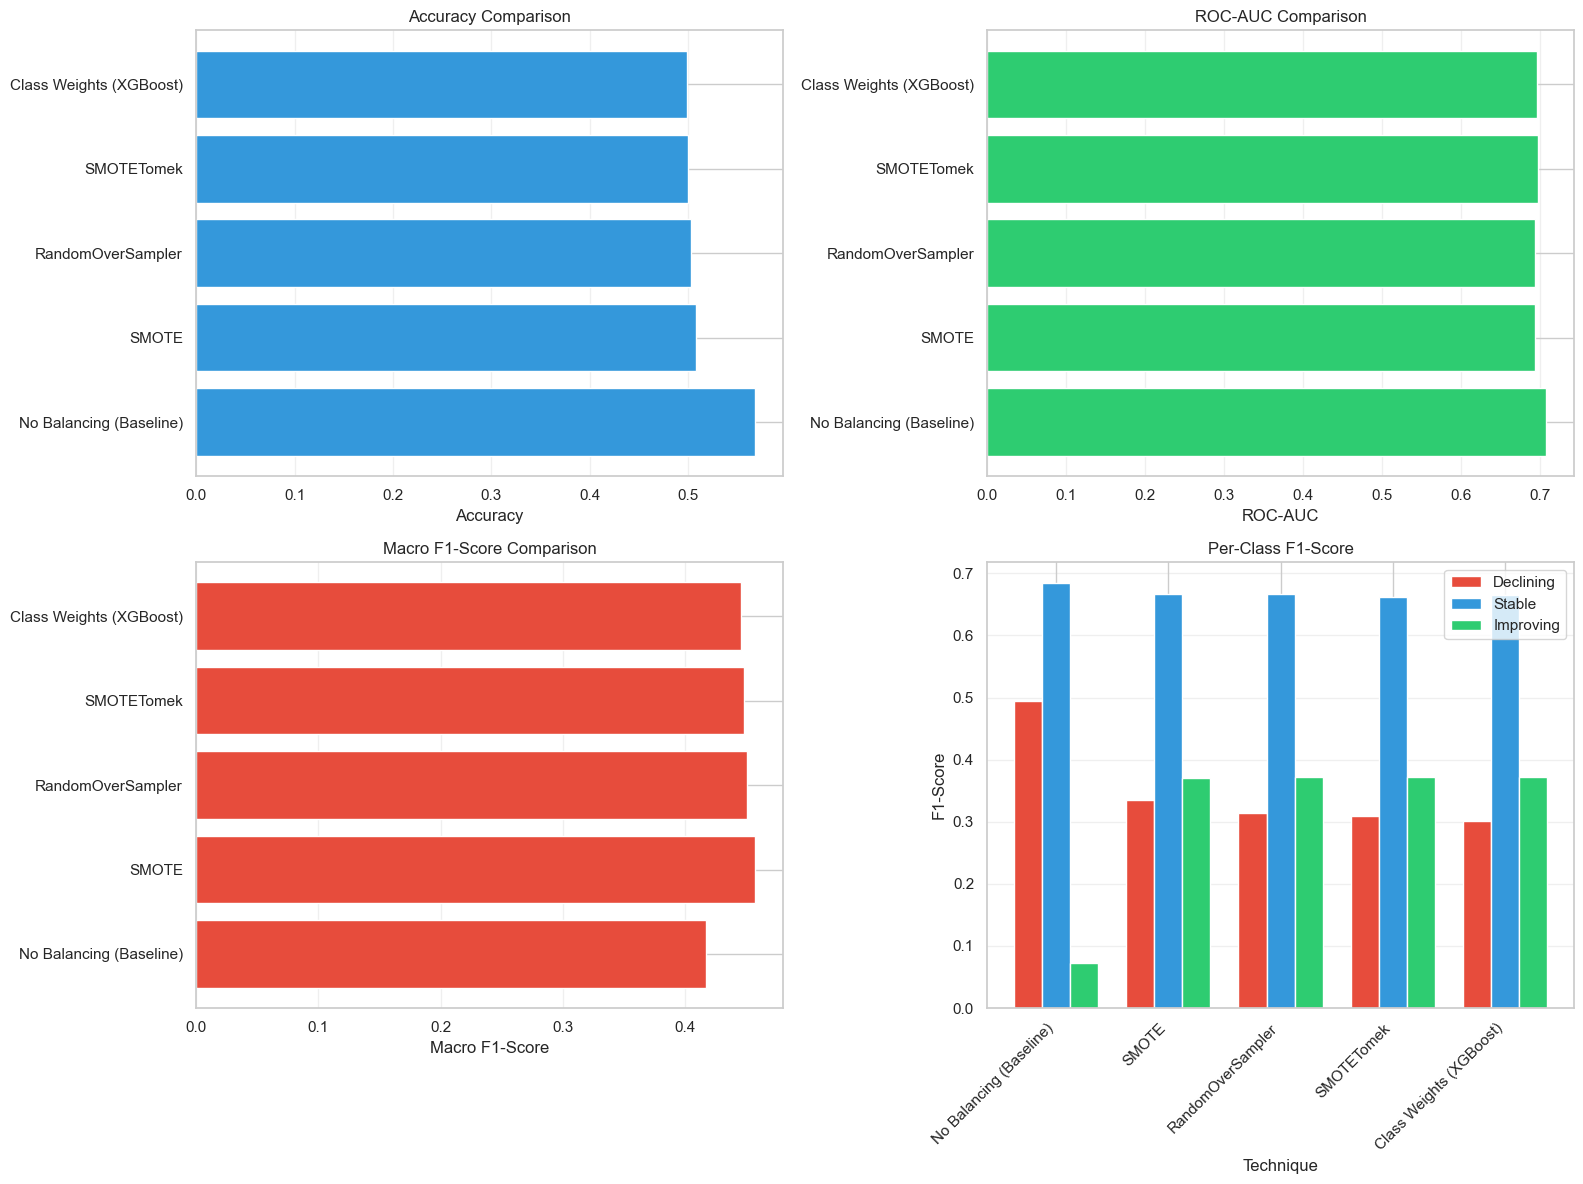


📊 Chart saved as 'balancing_comparison.png'


In [6]:
# Add baseline to comparison
baseline_result = {
    'Technique': 'No Balancing (Baseline)',
    'Accuracy': accuracy_score(y_test, y_pred_baseline),
    'ROC-AUC': roc_auc_score(y_test, y_prob_baseline, multi_class='ovr'),
    'Declining_F1': classification_report(y_test, y_pred_baseline, output_dict=True)['0']['f1-score'],
    'Stable_F1': classification_report(y_test, y_pred_baseline, output_dict=True)['1']['f1-score'],
    'Improving_F1': classification_report(y_test, y_pred_baseline, output_dict=True)['2']['f1-score'],
    'Macro_F1': classification_report(y_test, y_pred_baseline, output_dict=True)['macro avg']['f1-score']
}

results_df = pd.concat([pd.DataFrame([baseline_result]), results_df], ignore_index=True)

# Visualize
fig, axes = plt.subplots(2, 2, figsize=(16, 12))

# Accuracy
axes[0, 0].barh(results_df['Technique'], results_df['Accuracy'], color='#3498db')
axes[0, 0].set_xlabel('Accuracy')
axes[0, 0].set_title('Accuracy Comparison')
axes[0, 0].grid(axis='x', alpha=0.3)

# ROC-AUC
axes[0, 1].barh(results_df['Technique'], results_df['ROC-AUC'], color='#2ecc71')
axes[0, 1].set_xlabel('ROC-AUC')
axes[0, 1].set_title('ROC-AUC Comparison')
axes[0, 1].grid(axis='x', alpha=0.3)

# Macro F1
axes[1, 0].barh(results_df['Technique'], results_df['Macro_F1'], color='#e74c3c')
axes[1, 0].set_xlabel('Macro F1-Score')
axes[1, 0].set_title('Macro F1-Score Comparison')
axes[1, 0].grid(axis='x', alpha=0.3)

# Per-class F1
x = np.arange(len(results_df))
width = 0.25
axes[1, 1].bar(x - width, results_df['Declining_F1'], width, label='Declining', color='#e74c3c')
axes[1, 1].bar(x, results_df['Stable_F1'], width, label='Stable', color='#3498db')
axes[1, 1].bar(x + width, results_df['Improving_F1'], width, label='Improving', color='#2ecc71')
axes[1, 1].set_xlabel('Technique')
axes[1, 1].set_ylabel('F1-Score')
axes[1, 1].set_title('Per-Class F1-Score')
axes[1, 1].set_xticks(x)
axes[1, 1].set_xticklabels(results_df['Technique'], rotation=45, ha='right')
axes[1, 1].legend()
axes[1, 1].grid(axis='y', alpha=0.3)

plt.tight_layout()
plt.savefig('balancing_comparison.png', dpi=150, bbox_inches='tight')
plt.show()

print("\n📊 Chart saved as 'balancing_comparison.png'")


## 5. Recommendations


In [7]:
# Find best technique
best_idx = results_df['Macro_F1'].idxmax()
best_technique = results_df.iloc[best_idx]

print("=" * 60)
print("RECOMMENDATIONS")
print("=" * 60)
print(f"\n✅ Best Overall Technique: {best_technique['Technique']}")
print(f"   Macro F1: {best_technique['Macro_F1']:.4f}")
print(f"   Accuracy: {best_technique['Accuracy']:.4f}")
print(f"   ROC-AUC: {best_technique['ROC-AUC']:.4f}")

# Find best for Improving class
best_improving_idx = results_df['Improving_F1'].idxmax()
best_improving = results_df.iloc[best_improving_idx]

print(f"\n✅ Best for 'Improving' Class: {best_improving['Technique']}")
print(f"   Improving F1: {best_improving['Improving_F1']:.4f}")

print("\n" + "=" * 60)
print("SUMMARY")
print("=" * 60)
print("\nKey Findings:")
print(f"1. Class imbalance ratio: {imbalance_ratio:.1f}:1")
print(f"2. 'Improving' class is the minority ({train_dist.min()} samples)")
print(f"3. Baseline model struggles with 'Improving' class")
print(f"4. Best balancing technique improves macro F1 by {best_technique['Macro_F1'] - baseline_result['Macro_F1']:.4f}")

print("\nNext Steps:")
print("- Use the best technique in final model training")
print("- Consider ensemble methods combining multiple techniques")
print("- Try cost-sensitive learning with custom class weights")


RECOMMENDATIONS

✅ Best Overall Technique: SMOTE
   Macro F1: 0.4575
   Accuracy: 0.5081
   ROC-AUC: 0.6940

✅ Best for 'Improving' Class: RandomOverSampler
   Improving F1: 0.3727

SUMMARY

Key Findings:
1. Class imbalance ratio: 3.5:1
2. 'Improving' class is the minority (1313 samples)
3. Baseline model struggles with 'Improving' class
4. Best balancing technique improves macro F1 by 0.0405

Next Steps:
- Use the best technique in final model training
- Consider ensemble methods combining multiple techniques
- Try cost-sensitive learning with custom class weights
